# 3 RNN
After we have tried CNN, we also want to try RNN. And we use **LSTM** to build the model.  
LSTM stands for Long-Short Term Memory. LSTM is a type of recurrent neural network but is better than traditional recurrent neural networks in terms of memory. Having a good hold over memorizing certain patterns LSTMs perform fairly better. As with every other NN, LSTM can have multiple hidden layers and as it passes through every layer, the relevant information is kept and all the irrelevant information gets discarded in every single cell. How does it do the keeping and discarding you ask?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
from torch import nn
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 2022
torch.manual_seed(SEED)
torch.backends.cuda.deterministic = True

Mounted at /content/drive


In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.6 MB/s 


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/DataSolveUS_BIA667_Project/data/train_data.csv')

data['labels'] = data['cat_id_all']
data = data[["text","labels"]]

data

,text,labels
0,consent matter solium services llc solium serv...,"20,37,6,4,18,24,42"
1,alberta warns investors top investment risks y...,"2,3,25,9"
2,exempt dealer agrees settlement alberta asc co...,"34,1,20,29,4,37,8,24"
3,canadian regulators announces consultation acc...,"17,40,24,30,29"
4,csa consultation paper consideration access eq...,"17,21,30,40,29"
...,...,...
9854,difficulty repaying loans good track record co...,"9,21"
9855,russia restricted foreign blocked internationa...,"13,2,1,14,8,34,29,11,21"
9856,application pecuniary administrative sanction ...,"3,0,17,44,23"
9857,investor consultation investor service hotline...,"13,46"


In [ ]:
from keras.preprocessing.text import Tokenizer

train_text = data['text'].values
train_text = [text.split(' ') for text in train_text]

from collections import Counter

word_dict = Counter([word for sentence in train_text for word in sentence])
low_frequency_words = []
high_frequency_words = []
low_frequency_words = [k for (k,v) in  word_dict.items() if v <5]
high_frequency_words = [k for (k,v) in  word_dict.most_common(6)]

short_words = [k for (k,v) in  word_dict.items() if len(k)<2]
short_words.append('\'s')

remove_set = set(low_frequency_words + high_frequency_words + short_words)

train_text = [' '.join([word for word in sentence if not word in remove_set]) for sentence in train_text]


MAX_NB_WORDS = len(word_dict) - len(remove_set)
# MAX_NB_WORDS = 28551
print(MAX_NB_WORDS) 

MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

12371
Found 12372 unique tokens.


In [ ]:
from keras.utils import pad_sequences

X = tokenizer.texts_to_sequences(train_text)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
print('Shape of data tensor:', X[0:5])

Shape of data tensor: (9859, 250)
Shape of data tensor: [[   0    0    0 ...  216  623  317]
 [   0    0    0 ...  985 2850 3057]
 [   0    0    0 ...  172  691 4150]
 [   0    0    0 ...  182 1855   95]
 [   0    0    0 ...  290  264  541]]


In [ ]:
labels_num = 50
Y = torch.zeros((len(X), labels_num))
for index in range(len(X)):
  temp = data['labels'][index].split(',')
  temp = [int(i) for i in temp]
  Y[index][temp] =1

print('Shape of label tensor:', Y.shape)
print(Y[0:5])

Shape of label tensor: torch.Size([9859, 50])
tensor([[0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = random.seed(SEED))
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8873, 250) torch.Size([8873, 50])
(986, 250) torch.Size([986, 50])


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence 

class LSTM_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.IntTensor(featuers)
        self.labels = torch.Tensor(labels)
        

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.length

In [ ]:
train_dataset = LSTM_dataset(X_train, Y_train)
test_dataset = LSTM_dataset(X_test, Y_test)

In [ ]:
hidden_dim = 300
n_layers= 1

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(word_index), embedding_dim=MAX_SEQUENCE_LENGTH)
        self.lstm = nn.LSTM(input_size=MAX_SEQUENCE_LENGTH, hidden_size=hidden_dim, dropout = 0.2, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 50, bias = True)
        # self.act = nn.Sigmoid()

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        hidden = hidden.to(device)
        carry = carry.to(device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        output = self.linear(output[:,-1])
        # output = self.act(output)
        return output

In [ ]:
model = LSTM()
model = model.to(device)
model

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (embedding_layer): Embedding(12372, 250)
  (lstm): LSTM(250, 300, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=300, out_features=50, bias=True)
)

In [ ]:
from torchmetrics.classification import MultilabelF1Score
metric = MultilabelF1Score(num_labels=50).to(device)

def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size= 256):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)

            # forward
            # outputs = model(x).view(-1)
            outputs = model(x)
            pred = torch.round(outputs)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = metric(pred, y)
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # print(x.shape,y.shape)
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                # outputs = model(x).view(-1)
                outputs = model(x)
                pred = torch.round(outputs)
                
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = metric(pred, y)
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss / len(train_loader)).item()
        train_acc = train_acc / len(train_loader)
        val_loss = (test_loss / len(test_loader)).item()
        val_acc = test_acc / len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.cpu().numpy())
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc.cpu().numpy())
        print(
            f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.5f}")

    return history

history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0001,
                      epochs= 100,
                      batch_size= 256)

Training Start
Epoch:1 / 100, train loss:0.0277 train_acc:0.9551, valid loss:0.1794 valid acc:0.66662
Epoch:2 / 100, train loss:0.0256 train_acc:0.9624, valid loss:0.1808 valid acc:0.66887
Epoch:3 / 100, train loss:0.0245 train_acc:0.9663, valid loss:0.1816 valid acc:0.66751
Epoch:4 / 100, train loss:0.0236 train_acc:0.9697, valid loss:0.1831 valid acc:0.67215
Epoch:5 / 100, train loss:0.0228 train_acc:0.9717, valid loss:0.1837 valid acc:0.67043
Epoch:6 / 100, train loss:0.0220 train_acc:0.9746, valid loss:0.1847 valid acc:0.66936
Epoch:7 / 100, train loss:0.0213 train_acc:0.9760, valid loss:0.1859 valid acc:0.67228
Epoch:8 / 100, train loss:0.0207 train_acc:0.9783, valid loss:0.1868 valid acc:0.67358
Epoch:9 / 100, train loss:0.0200 train_acc:0.9796, valid loss:0.1888 valid acc:0.67227
Epoch:10 / 100, train loss:0.0194 train_acc:0.9814, valid loss:0.1894 valid acc:0.67394
Epoch:11 / 100, train loss:0.0189 train_acc:0.9826, valid loss:0.1895 valid acc:0.67470
Epoch:12 / 100, train loss

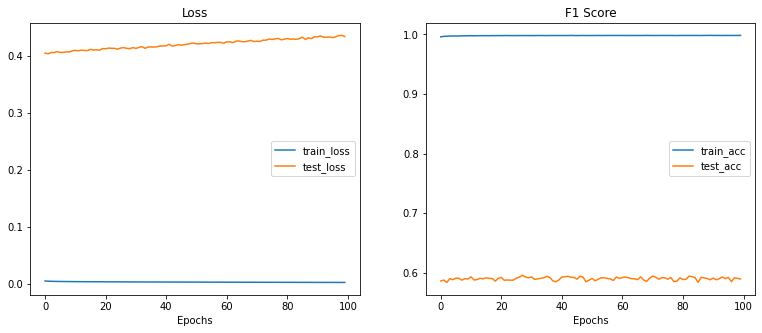

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (13,5))
ax[0].plot(range(100), history['train_loss'], label = "train_loss")
ax[0].plot(range(100), history['test_loss'], label = "test_loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(range(100), history['train_acc'], label = "train_acc")
ax[1].plot(range(100), history['test_acc'], label = "test_acc")
ax[1].set_title('F1 Score')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()

Above this is the best F1 score **0.67** **LSTM** reached. No matter num_layers and embedding_dim.

So as we can say LSTM is not good for this question. Althought LSTM can remember the sequence of words, but it only works on smart texts.